# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview : MA Release v1.0 - 26/03/2023

<p align="justify">EY Open Science Data Challenge 2023! The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. By the time you complete this level, you will have developed a rice crop classification model, which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, I will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, i have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a Random forest regression model with these features. I have extracted the VV band and VH band data from the Sentinel-1 dataset for the period of one year for a given location.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('-------------------')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [5]:
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head()
#crop_presence_data.drop(crop_presence_data.index[4:], axis=0, inplace=True)

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [4]:
crop_presence_data.info

<bound method DataFrame.info of                        Latitude and Longitude Class of Land
0     (10.323727047081501, 105.2516346045924)          Rice
1    (10.322364360592521, 105.27843410554115)          Rice
2    (10.321455902933202, 105.25254306225168)          Rice
3    (10.324181275911162, 105.25118037576274)          Rice
4    (10.324635504740822, 105.27389181724476)          Rice
..                                        ...           ...
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)      Non Rice
598  (10.012580298764401, 105.67361318732796)      Non Rice
599  (10.012126069934741, 105.67361318732796)      Non Rice

[600 rows x 2 columns]>

## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify"> Extract VV and VH band values for an entire year. Different land classes (e.g., agriculture, water, urban) will have different annual variability. This variability will be better than a single date for accurately identifying land classes. Please find below a demonstration of extracting data for a day (21st March 2020).

In [6]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees

resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 


<h4>Function call and Test Application</h4>
 
Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands (VV, VH) since they are needed to create the Radar Vegetation Index (RVI). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees and we have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. 

In [7]:
def get_sentinel_data(latlong,time_slice):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')  #extract longitude and latitude
    box_size_deg = 0.0004                                                       #define bounding box
    min_lon = float(latlong[1]) - box_size_deg/2                                # Surrounding box in degrees, yields approximately 5x5 pixel region
    max_lon = float(latlong[1]) + box_size_deg/2
    min_lat = float(latlong[0]) - box_size_deg/2
    max_lat = float(latlong[0]) + box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())

    
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items()) # This produces a list of scene IDs
    
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale)

    return data

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

In [ ]:
""" 
    Loop Function call to extract and store Data for each coordinate in the data store below

"""
time_slice = "2021-11-01/2022-08-30"       #period for analysis
data_store = []           # our data collector

for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    data_store.append(get_sentinel_data(coordinates,time_slice))

In [ ]:
df= pd.DataFrame()       #empty pandas dataframe

for x in data_store:     #generative for loop to iterate over our data store and apply necessary steps to convert into usuable df logic

    mean = x.mean(dim=['latitude','longitude']).compute()          #average long and lat range(bbox) to get average VV/VH/DVI over coordinate  

    vv = mean.vv
    vv = vv.to_dataframe()                  #convert xarray dataset to pandas dataframe
    vv.drop('spatial_ref', inplace=True, axis=1)    #drop spatial reference column
    vv = vv.pivot_table(columns='time')       #transpose the table on 'time' index/rows into list of columns 
    vv.reset_index(drop=True, inplace=True)    #reset index to default 
    vv.columns = vv.columns.map(lambda x: x.strftime('VV %Y-%m-%d'))    #Lambda function to convert all column name to date format with string prefix assigned
    vv=vv.T[~vv.T.index.duplicated(keep='last')].T         #if duplicate exist on column then remove

    vh = mean.vh
    vh = vh.to_dataframe()
    vh.drop('spatial_ref', inplace=True, axis=1)
    vh = vh.pivot_table(columns='time')
    vh.reset_index(drop=True, inplace=True)
    vh.columns = vh.columns.map(lambda x: x.strftime('VH %Y-%m-%d'))
    vh=vh.T[~vh.T.index.duplicated(keep='last')].T

    dop = (mean.vv / (mean.vv + mean.vh))    # Calculate RVI Radar vegetation Index
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*mean.vh)/(mean.vv + mean.vh))
    rvi = rvi.to_dataframe('rvi')
    rvi.drop('spatial_ref', inplace=True, axis=1)
    rvi = rvi.pivot_table(columns='time')
    rvi.reset_index(drop=True, inplace=True)
    rvi.columns = rvi.columns.map(lambda x: x.strftime('RVI %Y-%m-%d'))
    rvi=rvi.T[~rvi.T.index.duplicated(keep='last')].T
    
    result = pd.concat([vv,vh,rvi], axis=1)                #concatenate all dataframes in a single df/table
    df = df.append(result)                                 #send result out into empty df outside loop



In [ ]:
#reset the index of gathered data
df.reset_index(drop=True, inplace=True)
df.shape
print(end='\n')
df

In [93]:
#save data processing results
df.to_csv("store.csv", index=False)

In [2]:
# recalling store data for modelling  
df = pd.read_csv("store.csv")

df.shape

(600, 156)

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [3]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [6]:
crop_data = combine_two_datasets(crop_presence_data,df)
crop_data.head()

,Latitude and Longitude,Class of Land,VV 2021-11-04,VV 2021-11-10,VV 2021-11-11,VV 2021-11-16,VV 2021-11-22,VV 2021-11-23,VV 2021-11-28,VV 2021-12-04,...,RVI 2022-06-26,RVI 2022-06-27,RVI 2022-07-08,RVI 2022-07-09,RVI 2022-07-21,RVI 2022-08-01,RVI 2022-08-02,RVI 2022-08-14,RVI 2022-08-25,RVI 2022-08-26
0,"(10.323727047081501, 105.2516346045924)",Rice,0.085078,0.103747,0.141528,0.116194,0.226458,0.058069,0.231663,0.161205,...,0.589837,0.993113,0.602891,0.552731,0.603144,0.655350,0.432936,0.471715,0.236284,0.290553
1,"(10.322364360592521, 105.27843410554115)",Rice,0.082392,0.215120,0.120715,0.092254,0.136864,0.074702,0.284714,0.098242,...,0.951499,0.921718,0.932209,0.592974,0.850943,0.484364,0.528684,0.908461,0.188856,0.087447
2,"(10.321455902933202, 105.25254306225168)",Rice,0.091357,0.094915,0.084796,0.099805,0.174607,0.086904,0.159134,0.219693,...,1.058681,1.010928,1.036065,0.618302,1.024155,0.694684,0.766197,0.700090,0.145994,0.151130
3,"(10.324181275911162, 105.25118037576274)",Rice,0.101169,0.102374,0.090052,0.100401,0.220873,0.098757,0.171393,0.247526,...,0.873561,0.868383,0.607660,0.491217,0.574914,0.268481,0.512498,0.629856,0.383905,0.137984
4,"(10.324635504740822, 105.27389181724476)",Rice,0.060296,0.097322,0.102012,0.164338,0.313654,0.167324,0.178758,0.028740,...,0.908775,0.673818,0.685046,0.668283,0.895021,0.640925,0.602882,0.699218,0.147155,0.162441


## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [7]:
crop_data.columns

Index(['Latitude and Longitude', 'Class of Land', 'VV 2021-11-04',
       'VV 2021-11-10', 'VV 2021-11-11', 'VV 2021-11-16', 'VV 2021-11-22',
       'VV 2021-11-23', 'VV 2021-11-28', 'VV 2021-12-04',
       ...
       'RVI 2022-06-26', 'RVI 2022-06-27', 'RVI 2022-07-08', 'RVI 2022-07-09',
       'RVI 2022-07-21', 'RVI 2022-08-01', 'RVI 2022-08-02', 'RVI 2022-08-14',
       'RVI 2022-08-25', 'RVI 2022-08-26'],
      dtype='object', length=158)

In [8]:
crop_data = crop_data.drop(['Latitude and Longitude'], axis = 1)
crop_data

,Class of Land,VV 2021-11-04,VV 2021-11-10,VV 2021-11-11,VV 2021-11-16,VV 2021-11-22,VV 2021-11-23,VV 2021-11-28,VV 2021-12-04,VV 2021-12-05,...,RVI 2022-06-26,RVI 2022-06-27,RVI 2022-07-08,RVI 2022-07-09,RVI 2022-07-21,RVI 2022-08-01,RVI 2022-08-02,RVI 2022-08-14,RVI 2022-08-25,RVI 2022-08-26
0,Rice,0.085078,0.103747,0.141528,0.116194,0.226458,0.058069,0.231663,0.161205,0.204640,...,0.589837,0.993113,0.602891,0.552731,0.603144,0.655350,0.432936,0.471715,0.236284,0.290553
1,Rice,0.082392,0.215120,0.120715,0.092254,0.136864,0.074702,0.284714,0.098242,0.061131,...,0.951499,0.921718,0.932209,0.592974,0.850943,0.484364,0.528684,0.908461,0.188856,0.087447
2,Rice,0.091357,0.094915,0.084796,0.099805,0.174607,0.086904,0.159134,0.219693,0.116170,...,1.058681,1.010928,1.036065,0.618302,1.024155,0.694684,0.766197,0.700090,0.145994,0.151130
3,Rice,0.101169,0.102374,0.090052,0.100401,0.220873,0.098757,0.171393,0.247526,0.191711,...,0.873561,0.868383,0.607660,0.491217,0.574914,0.268481,0.512498,0.629856,0.383905,0.137984
4,Rice,0.060296,0.097322,0.102012,0.164338,0.313654,0.167324,0.178758,0.028740,0.034981,...,0.908775,0.673818,0.685046,0.668283,0.895021,0.640925,0.602882,0.699218,0.147155,0.162441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Non Rice,0.469439,0.309315,0.190669,0.460000,0.569655,0.280834,0.418029,0.553822,0.239805,...,0.744395,0.602288,0.767856,0.954390,0.808105,0.619861,0.820922,0.711260,0.744156,0.639115
596,Non Rice,0.339241,0.278809,0.298743,0.385769,0.352395,0.211267,0.387216,0.409666,0.187139,...,0.662645,0.601369,0.761091,0.718749,0.714974,0.842153,0.998486,0.832898,0.677540,0.721661
597,Non Rice,0.269154,0.269148,0.275597,0.395252,0.295670,0.200422,0.322652,0.381657,0.231687,...,0.570526,0.718923,0.532632,0.733108,0.508147,0.812409,0.602666,0.925871,0.621314,0.574596
598,Non Rice,0.442121,0.350665,0.244101,0.310633,0.294829,0.291600,0.244322,0.377818,0.239637,...,0.748859,0.658871,0.706759,0.711325,0.762945,0.837089,0.648782,0.714025,0.852643,0.674228


### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [9]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of VV and VH variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">Participants might explore other feature scaling techniques like Min Max Scaler, Max Absolute Scaling, Robust Scaling etc.</p>

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [17]:
#logistic regression model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [44]:
#Random forrest classifier

from sklearn import model_selection           #for implementing cross validation
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)  

rf = RandomForestClassifier(n_estimators=400, random_state=11, max_depth=None).fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(f"RF Model F1 Score is: {f1_score(y_test, y_pred, average='macro')}")
print(f"RF Model Accuracy is: {accuracy_score(y_test, y_pred)}")
print(f"RF Model Precision is: {metrics.precision_score(y_test, y_pred, average='macro')}")
print(f"RF Model Recall is: {metrics.recall_score(y_test, y_pred, average='macro')}")
print(end='\n')

# Return Sturctured Classification Report
print(classification_report(y_test, y_pred))



RF Model F1 Score is: 0.994444272971388
RF Model Accuracy is: 0.9944444444444445
RF Model Precision is: 0.9945054945054945
RF Model Recall is: 0.9944444444444445

              precision    recall  f1-score   support

    Non Rice       1.00      0.99      0.99        90
        Rice       0.99      1.00      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [72]:
# Implementing Grid Search to explore the hyperparameters on Random forrest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest Classifier
rfc = RandomForestClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [70],
    'max_depth': [None],
    'min_samples_split': [5],
    'min_samples_leaf': [6],
    'random_state' : [5,7,11,14]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train,y_train)

# Print the best parameters and best score and then apply to random forrest classifier in cell above
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 70, 'random_state': 5}
Best Score:  1.0


In [43]:
# Neural NEtwork MLP:
from sklearn.neural_network import MLPClassifier

#Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data  


# Implementing Grid Search to explore the hyperparameters on MLP
from sklearn.model_selection import GridSearchCV

param_grid = [
        {
            'activation' : ['identity', 'logistic'],
            'solver' : ['lbfgs', 'adam'],
            'hidden_layer_sizes': [
             (1,2),(2,3),(3,),(4,),(5,),(10,),(12,4),(16,2),(17,),(18,),(20,)
             ],
            'max_iter' : [2000]
        }
       ]

clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,
                           scoring='accuracy')
clf.fit(X_train,y_train)


print("Best parameters set found on development set:")
print(clf.best_params_)

print(end='\n')



Best parameters set found on development set:
{'activation': 'identity', 'hidden_layer_sizes': (12, 4), 'max_iter': 2000, 'solver': 'lbfgs'}


In [ ]:
#Use parameters from Grid search as args below
mlp2 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(12,4), max_iter=2000, activation='identity').fit(X_train,y_train)
y_pred = mlp2.predict(X_test)
print(f"mlp Model Accuracy is: {accuracy_score(y_test, y_pred)}")

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [26]:
insample_predictions = rf.predict(X_train)

In [27]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       210
        Rice       1.00      1.00      1.00       210

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [28]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

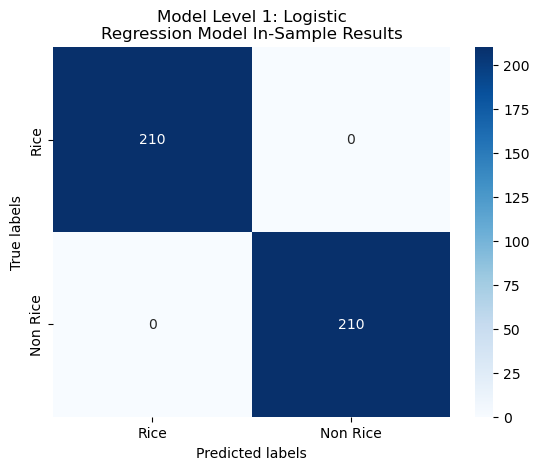

In [29]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [30]:
outsample_predictions = rf.predict(X_test)

In [31]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 99.44%
              precision    recall  f1-score   support

    Non Rice       1.00      0.99      0.99        90
        Rice       0.99      1.00      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



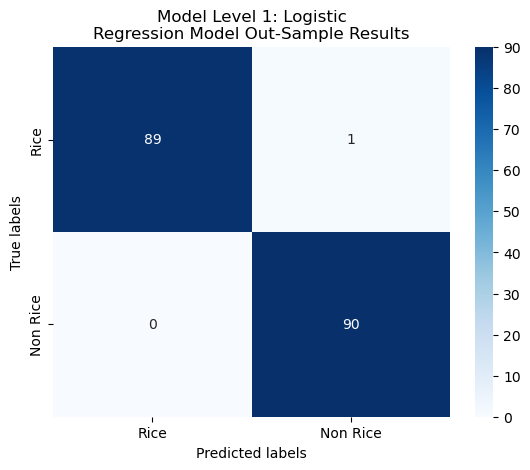

In [32]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [33]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"


In [34]:
#Test section
# test_file.drop(test_file.index[2:], axis=0, inplace=True)

In [35]:
test_file.shape

(250, 1)

In [29]:
## Get Sentinel-1-RTC Data
time_slice = "2021-11-01/2022-08-30"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice))
#submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 250/250 [1:41:57<00:00, 24.47s/it]


In [30]:
vh_vv[0]['time']

<xarray.DataArray 'time' (time: 52)>
array(['2021-11-04T22:45:36.411115000', '2021-11-10T22:46:08.655270000',
       '2021-11-11T11:11:55.398152000', '2021-11-16T22:45:36.313857000',
       '2021-11-22T22:46:08.483277000', '2021-11-23T11:11:55.171527000',
       '2021-11-28T22:45:35.799166000', '2021-12-04T22:46:07.919581000',
       '2021-12-05T11:11:54.609425000', '2021-12-10T22:45:35.316746000',
       '2021-12-16T22:46:07.511215000', '2021-12-17T11:11:54.196354000',
       '2021-12-22T22:45:34.433936000', '2021-12-28T22:46:06.761481000',
       '2021-12-29T11:11:53.438580000', '2022-01-09T22:46:06.347730000',
       '2022-01-10T11:11:53.057355000', '2022-01-21T22:46:05.657153000',
       '2022-01-22T11:11:52.377922000', '2022-02-02T22:46:04.929540000',
       '2022-02-03T11:11:51.699083000', '2022-02-14T22:46:05.071585000',
       '2022-02-15T11:11:51.767747000', '2022-02-26T22:46:04.969244000',
       '2022-03-10T22:46:04.925705000', '2022-03-11T11:11:51.691272000',
       '2022-03-22T22:46:05.287764000', '2022-03-23T11:11:52.064532000',
       '2022-04-03T22:46:05.477503000', '2022-04-04T11:11:52.234391000',
       '2022-04-15T22:46:05.644861000', '2022-04-16T11:11:52.470632000',
       '2022-04-27T22:46:06.296981000', '2022-04-28T11:11:53.135539000',
       '2022-05-09T22:46:06.912236000', '2022-05-10T11:11:53.723854000',
       '2022-05-21T22:46:07.705465000', '2022-05-22T11:11:54.509303000',
       '2022-06-02T22:46:08.840031000', '2022-06-03T11:11:55.667800000',
       '2022-06-14T22:46:09.386909000', '2022-06-15T11:11:56.125679000',
       '2022-06-26T22:46:10.363160000', '2022-06-27T11:11:57.147850000',
       '2022-07-08T22:46:10.959030000', '2022-07-09T11:11:57.770925000',
       '2022-07-21T11:11:58.504828000', '2022-08-01T22:46:12.528362000',
       '2022-08-02T11:11:59.338449000', '2022-08-14T11:12:00.071377000',
       '2022-08-25T22:46:14.709082000', '2022-08-26T11:12:00.463421000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-11-04T22:45:36.411115 ... 2022-08...

In [81]:
submission_vh_vv_data= pd.DataFrame()       #empty pandas dataframe

for x in vh_vv:     #generative for loop to iterate over our data store and apply necessary steps to convert into usuable df logic

    mean = x.mean(dim=['latitude','longitude']).compute()          #average long and lat range(bbox) to get average VV/VH/DVI over coordinate  

    vv = mean.vv
    vv = vv.to_dataframe()                  #convert xarray dataset to pandas dataframe
    vv.drop('spatial_ref', inplace=True, axis=1)    #drop spatial reference column
    vv = vv.pivot_table(columns='time')       #transpose the table on 'time' index/rows into list of columns 
    vv.reset_index(drop=True, inplace=True)    #reset index to default 
    vv.columns = vv.columns.map(lambda x: x.strftime('VV %Y-%m-%d'))    #Lambda function to convert all column name to date format with string prefix assigned
    vv=vv.T[~vv.T.index.duplicated(keep='last')].T         #if duplicate exist on column then remove

    vh = mean.vh
    vh = vh.to_dataframe()
    vh.drop('spatial_ref', inplace=True, axis=1)
    vh = vh.pivot_table(columns='time')
    vh.reset_index(drop=True, inplace=True)
    vh.columns = vh.columns.map(lambda x: x.strftime('VH %Y-%m-%d'))
    vh=vh.T[~vh.T.index.duplicated(keep='last')].T

    dop = (mean.vv / (mean.vv + mean.vh))    # Calculate RVI Radar vegetation Index
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*mean.vh)/(mean.vv + mean.vh))
    rvi = rvi.to_dataframe('rvi')
    rvi.drop('spatial_ref', inplace=True, axis=1)
    rvi = rvi.pivot_table(columns='time')
    rvi.reset_index(drop=True, inplace=True)
    rvi.columns = rvi.columns.map(lambda x: x.strftime('RVI %Y-%m-%d'))
    rvi=rvi.T[~rvi.T.index.duplicated(keep='last')].T
    
    result = pd.concat([vv,vh,rvi], axis=1)                #concatenate all dataframes in a single df/table
    submission_vh_vv_data = submission_vh_vv_data.append(result)                                 #send result out into empty df outside loop

In [82]:
submission_vh_vv_data.reset_index(drop=True, inplace=True)
submission_vh_vv_data.head()

time,VV 2021-11-04,VV 2021-11-10,VV 2021-11-11,VV 2021-11-16,VV 2021-11-22,VV 2021-11-23,VV 2021-11-28,VV 2021-12-04,VV 2021-12-05,VV 2021-12-10,...,RVI 2022-06-26,RVI 2022-06-27,RVI 2022-07-08,RVI 2022-07-09,RVI 2022-07-21,RVI 2022-08-01,RVI 2022-08-02,RVI 2022-08-14,RVI 2022-08-25,RVI 2022-08-26
0,0.011238,0.008715,0.012969,0.010551,0.014628,0.014803,0.013431,0.008987,0.007270,0.012203,...,0.785152,0.734679,0.858956,0.932741,0.718733,0.388959,0.352628,0.342057,0.365078,0.493889
1,0.010149,0.010564,0.043352,0.007229,0.016378,0.025697,0.009900,0.007967,0.036262,0.007039,...,0.866087,0.723486,0.857754,0.888209,0.928014,0.479017,0.459849,0.537319,0.709433,0.724080
2,0.108991,0.075174,0.076769,0.027518,0.030112,0.054172,0.026933,0.029800,0.053016,0.024547,...,0.754909,0.965200,0.867237,0.533282,0.676945,0.820860,0.804863,0.380770,0.710452,0.808880
3,0.007682,0.014184,0.015251,0.007949,0.012796,0.014073,0.009994,0.014225,0.015645,0.011348,...,0.856625,0.747937,0.868692,0.688991,1.114499,0.725051,0.726753,0.569186,0.480176,1.128619
4,0.011144,0.008227,0.024023,0.004611,0.035945,0.036831,0.015734,0.060342,0.053864,0.055162,...,0.989964,1.018154,0.491679,0.337446,0.550406,0.467019,0.596292,0.345243,0.651412,0.531299


In [83]:
submission_vh_vv_data.to_csv("submission_vh_vv_data.csv", index=False)

In [36]:
submission_vh_vv_data = pd.read_csv("submission_vh_vv_data.csv")

In [37]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [45]:
#Making predictions
final_predictions = rf.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [46]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series.values})

In [47]:
#Displaying the sample submission dataframe
display(submission_df)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [48]:
submission_df.columns

Index(['Latitude and Longitude', 'Class of Land'], dtype='object')

In [49]:
submission_df.rename
submission_df = submission_df.rename(columns={'Latitude and Longitude': 'id'})
submission_df = submission_df.rename(columns={'Class of Land': 'target'})

In [50]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)